# Machine-Learning test

- `xgboost`, `lightgbm`あたりの手法を`sklearn`のpipeline, gridsearchCVと組み合わせて使えるようにする（目標）


---

### sklearn
- https://qiita.com/R0w0/items/3b3d8e660b8abc1f804d
- https://qiita.com/ishizakiiii/items/0650723cc2b4eef2c1cf
- https://qiita.com/yhyhyhjp/items/c81f7cea72a44a7bfd3a
- https://qiita.com/saiaron/items/bb96c0f898cd0cbcd788
- https://qiita.com/issakuss/items/d30303e200756980ae45


### xgboost
- http://wolfin.hatenablog.com/entry/2018/02/08/092124
- http://tekenuko.hatenablog.com/entry/2016/09/22/220814
- https://qiita.com/katsu1110/items/a1c3185fec39e5629bcb
- https://blog.amedama.jp/entry/2019/01/29/235642
- https://qiita.com/aaatsushi_bb/items/0b605c0f27493f005c88
- http://smrmkt.hatenablog.jp/entry/2015/04/28/210039
- https://qiita.com/msrks/items/e3e958c04a5167575c41
- https://yag.xyz/blog/2015/08/08/xgboost-python/
- http://wolfin.hatenablog.com/entry/2018/02/08/092124

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [1]:
import numpy as np
import dask.dataframe as dd
import seaborn as sns
from tensorflow import keras

In [11]:
import xgboost as xgb
import lightgbm as lgb

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

In [63]:
from sklearn.impute import SimpleImputer

In [16]:
import umap

- mpgのテストデータを使ってみる

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/home/jovyan/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [9]:
df_mpg = spark.createDataFrame(dataset.rename(columns={"Model Year":"Model_Year"}))
df_mpg.show()

+----+---------+------------+----------+------+------------+----------+------+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model_Year|Origin|
+----+---------+------------+----------+------+------------+----------+------+
|18.0|        8|       307.0|     130.0|3504.0|        12.0|        70|     1|
|15.0|        8|       350.0|     165.0|3693.0|        11.5|        70|     1|
|18.0|        8|       318.0|     150.0|3436.0|        11.0|        70|     1|
|16.0|        8|       304.0|     150.0|3433.0|        12.0|        70|     1|
|17.0|        8|       302.0|     140.0|3449.0|        10.5|        70|     1|
|15.0|        8|       429.0|     198.0|4341.0|        10.0|        70|     1|
|14.0|        8|       454.0|     220.0|4354.0|         9.0|        70|     1|
|14.0|        8|       440.0|     215.0|4312.0|         8.5|        70|     1|
|14.0|        8|       455.0|     225.0|4425.0|        10.0|        70|     1|
|15.0|        8|       390.0|     190.0|3850.0|     

In [10]:
%%time
df_mpg.write.saveAsTable("mpg", format="orc", compression="zlib", path="/home/jovyan/work/hive-db/external/tf_testdata/mpg")

CPU times: user 3.1 ms, sys: 574 µs, total: 3.68 ms
Wall time: 1.25 s


In [29]:
pdf_mpg = df_mpg.toPandas()

- make data

In [52]:
pdf_mpg_oneHot = pd.get_dummies(pdf_mpg, columns=['Origin'], drop_first=True)

In [56]:
y = pdf_mpg_oneHot.MPG.values
X = pdf_mpg_oneHot.drop(columns=["MPG"]).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [58]:
xgb_reg = xgb.XGBRegressor()

AttributeError: module 'xgboost' has no attribute 'fit'

In [61]:
from sklearn.preprocessing import normalize

In [64]:
imp = SimpleImputer(fill_value=-1)

In [65]:
imp.fit_transform(X)

array([[  8., 307., 130., ...,  70.,   0.,   0.],
       [  8., 350., 165., ...,  70.,   0.,   0.],
       [  8., 318., 150., ...,  70.,   0.,   0.],
       ...,
       [  4., 135.,  84., ...,  82.,   0.,   0.],
       [  4., 120.,  79., ...,  82.,   0.,   0.],
       [  4., 119.,  82., ...,  82.,   0.,   0.]])

- imputerを使うのはPipelineのテスト用で実質的な意味は無い

In [86]:
eval_results = {}

pl_xgb = Pipeline([
    ("IMP", SimpleImputer(fill_value=-99999)),
    ("XGB", xgb.XGBRegressor(early_stopping_rounds=20,
                             objective="reg:squarederror",
                             eval_metric="rmse",
                             callbacks=[xgb.callback.record_evaluation(eval_result=eval_results),],
                             random_state=0))
])

In [ ]:
params_grid = {'max_depth': [3, 5, 10], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 10, 100], 'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.5, 1.0]}

In [ ]:
grid_search = GridSearchCV

In [74]:
xgb.XGBRegressor(num_boost_round=1000, early_stopping_rounds=10)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, num_boost_round=1000,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [75]:
xgb.callback.record_evaluation

<function xgboost.callback.record_evaluation(eval_result)>

In [87]:
pl_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('IMP',
                 SimpleImputer(add_indicator=False, copy=True,
                               fill_value=-99999, missing_values=nan,
                               strategy='mean', verbose=0)),
                ('XGB',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              callbacks=[<function record_evaluation.<locals>.callback at 0x7f6e3c38f290>],
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=20,
                              eval_metric='rmse', gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='reg:squarederror',
                              random_state=0, reg_alpha=0,

In [88]:
eval_results

{}

In [85]:
pl_xgb.steps[1][1].evals_result()

AttributeError: 'XGBRegressor' object has no attribute 'evals_result_'

In [101]:
eval_results={}
model_xgb = xgb.XGBRegressor(early_stopping_rounds=20,
                             objective="reg:squarederror",
                             #eval_metric="rmse",
                             #eval_set=[(X_train, y_train), (X_test, y_test)],
                             callbacks=[xgb.callback.record_evaluation(eval_result=eval_results),],
                             random_state=0)

In [112]:
model_xgb.fit(X_train, y_train, eval_metric=["rmse","mae"],
                             eval_set=[(X_train, y_train), (X_test, y_test)],
             )

[0]	validation_0-rmse:21.8118	validation_0-mae:20.5916	validation_1-rmse:22.5818	validation_1-mae:21.3623
[1]	validation_0-rmse:19.7243	validation_0-mae:18.565	validation_1-rmse:20.4369	validation_1-mae:19.2547
[2]	validation_0-rmse:17.8449	validation_0-mae:16.746	validation_1-rmse:18.497	validation_1-mae:17.3613
[3]	validation_0-rmse:16.147	validation_0-mae:15.1091	validation_1-rmse:16.7731	validation_1-mae:15.6793
[4]	validation_0-rmse:14.6192	validation_0-mae:13.6342	validation_1-rmse:15.2189	validation_1-mae:14.1603
[5]	validation_0-rmse:13.2458	validation_0-mae:12.2962	validation_1-rmse:13.7888	validation_1-mae:12.7381
[6]	validation_0-rmse:12.0082	validation_0-mae:11.0965	validation_1-rmse:12.5248	validation_1-mae:11.4884
[7]	validation_0-rmse:10.9014	validation_0-mae:10.0091	validation_1-rmse:11.4168	validation_1-mae:10.3742
[8]	validation_0-rmse:9.90081	validation_0-mae:9.03015	validation_1-rmse:10.414	validation_1-mae:9.36821
[9]	validation_0-rmse:8.99963	validation_0-mae:8.14

XGBRegressor(base_score=0.5, booster='gbtree',
             callbacks=[<function record_evaluation.<locals>.callback at 0x7f6e3c38f0e0>],
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=20, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [106]:
eval_results

{}

In [113]:
a = model_xgb.evals_result()
a


{'validation_0': {'rmse': [21.811825,
   19.724339,
   17.844919,
   16.146986,
   14.619184,
   13.24578,
   12.008202,
   10.901402,
   9.900814,
   8.999632,
   8.19275,
   7.467234,
   6.818316,
   6.237907,
   5.719942,
   5.255979,
   4.844197,
   4.474569,
   4.144517,
   3.854015,
   3.601016,
   3.377367,
   3.178587,
   3.00759,
   2.853274,
   2.722594,
   2.593741,
   2.494678,
   2.393215,
   2.315109,
   2.249013,
   2.182474,
   2.128579,
   2.074581,
   2.028258,
   1.991305,
   1.959206,
   1.932026,
   1.904956,
   1.883814,
   1.852037,
   1.828669,
   1.812753,
   1.795653,
   1.772947,
   1.761117,
   1.746874,
   1.724908,
   1.713753,
   1.697321,
   1.687803,
   1.677184,
   1.661045,
   1.651923,
   1.638172,
   1.627604,
   1.615972,
   1.608628,
   1.596555,
   1.588943,
   1.578886,
   1.567693,
   1.557343,
   1.548904,
   1.532691,
   1.525887,
   1.518733,
   1.505136,
   1.496158,
   1.488168,
   1.483862,
   1.477749,
   1.473415,
   1.46805,
   1.46453

In [125]:
r2_score(y_pred=model_xgb.predict(X_test), y_true=y_test)

0.8442909508242775

In [126]:
model_xgb.feature_importances_

array([0.01506082, 0.36401403, 0.13824697, 0.34278297, 0.01711842,
       0.07688458, 0.03003405, 0.0158581 ], dtype=float32)

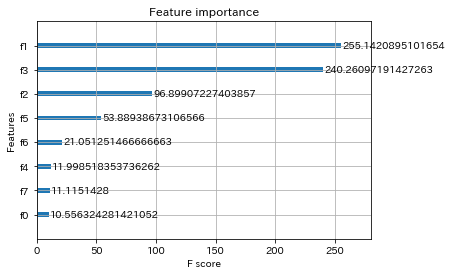

In [127]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()

xgb.plot_importance(model_xgb,
                   ax=ax,
                   importance_type="gain",
                   show_values=True)
plt.show()

- 使い方はともかく、こんな感じでプロット出来る（↑は見たい項目では無い気がするが。。。）

- callbacksの使い方がうまく出来ていないが、これでも最低限のことは出来ていそう

In [115]:
pd.DataFrame(a)

,validation_0,validation_1
rmse,"[21.811825, 19.724339, 17.844919, 16.146986, 1...","[22.581757, 20.436949, 18.496956, 16.773054, 1..."
mae,"[20.591619, 18.56496, 16.745995, 15.109141, 13...","[21.362328, 19.254726, 17.361317, 15.679334, 1..."


In [116]:
pd.DataFrame(a).to_parquet("tmp_fit_validation.snappy.parquet")

In [120]:
spark.read.load("tmp_fit_*parquet").show()
spark.read.load("tmp_fit_*parquet").printSchema()
spark.read.load("tmp_fit_*parquet").dtypes

+--------------------+--------------------+-----------------+
|        validation_0|        validation_1|__index_level_0__|
+--------------------+--------------------+-----------------+
|[21.811825, 19.72...|[22.581757, 20.43...|             rmse|
|[20.591619, 18.56...|[21.362328, 19.25...|              mae|
+--------------------+--------------------+-----------------+

root
 |-- validation_0: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- validation_1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- __index_level_0__: string (nullable = true)



[('validation_0', 'array<double>'),
 ('validation_1', 'array<double>'),
 ('__index_level_0__', 'string')]

In [128]:
pdf_mpg_oneHot

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0
